In [1]:
"""
Purpose: To run the soma splitting 
on the processed neurons

"""


'\nPurpose: To run the soma splitting \non the processed neurons\n\n'

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")

import datajoint_utils as du
from importlib import reload

INFO - 2021-01-13 23:25:15,289 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-13 23:25:15,291 - settings - Setting database.user to celiib
INFO - 2021-01-13 23:25:15,291 - settings - Setting database.password to newceliipass
INFO - 2021-01-13 23:25:15,310 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-01-13 23:25:15,310 - settings - Setting enable_python_native_blobs to True
INFO - 2021-01-13 23:25:15,323 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-01-13 23:25:15,630 - settings - Setting enable_python_native_blobs to True


In [3]:
test_mode = True

In [4]:
import minfig
import time
import numpy as np
#want to add in a wait for the connection part
random_sleep_sec = np.random.randint(0, 200)
print(f"Sleeping {random_sleep_sec} sec before conneting")
if not test_mode:
    time.sleep(random_sleep_sec)
print("Done sleeping")

du.config_celii()
du.set_minnie65_config_segmentation(minfig)
du.print_minnie65_config_paths(minfig)

#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-01-13 23:25:15,719 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-13 23:25:15,720 - settings - Setting database.user to celiib
INFO - 2021-01-13 23:25:15,721 - settings - Setting database.password to newceliipass
INFO - 2021-01-13 23:25:15,726 - settings - Setting enable_python_native_blobs to True


Sleeping 48 sec before conneting
Done sleeping
Current path for external_segmentation_path = /mnt/dj-stor01/platinum/minnie65/02
Current path for external_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/meshes
Current path for external_decimated_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/decimated_meshes
Current path for external_skeleton_path = /mnt/dj-stor01/platinum/minnie65/02/skeletons


INFO - 2021-01-13 23:25:15,996 - settings - Setting enable_python_native_blobs to True


# Defining the Table

In [5]:
import neuron_utils as nru
import neuron
import trimesh_utils as tu
import numpy as np

In [6]:
import meshlab
meshlab.set_meshlab_port(current_port=None)

No port chosen so picked random port 5253


In [7]:
#so that it will have the adapter defined
from datajoint_utils import *

In [8]:
import numpy as np
import time
import proofreading_utils as pru

@schema
class NeuronSplitSuggestions(dj.Computed):
    definition="""
    -> minnie.Decomposition
    ---
    split_results: longblob #will store the results of how to split the limbs of neuron objects
    run_time=NULL : double                   # the amount of time to run (seconds)

    """

    key_source = minnie.Decomposition()
    
    def make(self,key):
        """
        Pseudocode for process:

        1) Fetch the neuron object
        2) Run the mutli-split suggestions
        3) Calculate the total time
        4) Write the results to the table
        """
        whole_pass_time = time.time()
        #1) Get the segment id from the key
        segment_id = key["segment_id"]
        print(f"\n\n----- Working on Neuron {segment_id}-------")
        
        neuron_obj = (minnie.Decomposition & key).fetch1("decomposition")
        
        limb_results = pru.multi_soma_split_suggestions(neuron_obj,plot_intermediates=False)
        
        #7) Pass stats and file location to insert
        new_key = dict(key,
                       split_results = limb_results,
                       run_time=np.round(time.time() - whole_pass_time,4)
                      )

        self.insert1(new_key, allow_direct_insert=True, skip_duplicates=True)

        print(f"\n\n ------ Total time for Splitting {segment_id} = {time.time() - whole_pass_time} ------")
    

# Running the Populate

In [9]:
curr_table = (minnie.schema.jobs & "table_name='__neuron_split_suggestions'")
(curr_table)#.delete()# & "status='error'")
#curr_table.delete()
#(curr_table & "error_message = 'ValueError: need at least one array to concatenate'").delete()

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__neuron_split_suggestions,008c4d22e8e4c9b8eea4676f09706640,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10542,36039,2021-01-13 16:54:12
__neuron_split_suggestions,0cec0240576876905afc52bc010719e8,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10185,36032,2021-01-13 16:14:06
__neuron_split_suggestions,0e5cd6eab1b5f2e550cf30b458e990cf,error,=BLOB=,Exception: base_node (101) and upstream_node (136) are not connected in the concept network,=BLOB=,celiib@10.21.18.111,71caefafdeec,10479,36037,2021-01-13 16:57:56
__neuron_split_suggestions,13123179026cc7faebd655f15ef45844,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10542,36039,2021-01-13 16:59:28
__neuron_split_suggestions,29ef90c9bf67783e41258c6e923a177d,error,=BLOB=,Exception: base_node (68) and upstream_node (81) are not connected in the concept network,=BLOB=,celiib@10.21.18.111,71caefafdeec,10353,36034,2021-01-13 16:19:57
__neuron_split_suggestions,4b8616de1575f9dcfef86e69b2cdd0bc,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10416,36035,2021-01-13 16:30:20
__neuron_split_suggestions,4dd62a4a7f6e893aafc470b844f03f12,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10257,36033,2021-01-13 17:05:09
__neuron_split_suggestions,8e765a57fcf0e32ace865a137199826e,error,=BLOB=,Exception: base_node (34) and upstream_node (28) are not connected in the concept network,=BLOB=,celiib@10.21.18.111,71caefafdeec,10257,36033,2021-01-13 16:32:42
__neuron_split_suggestions,962778371ff53114b0f9fac08fb862dc,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10185,36032,2021-01-13 16:29:14
__neuron_split_suggestions,9afa904765a62664caa7d45238ddfa77,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10416,36035,2021-01-13 17:08:44


INFO - 2021-01-13 23:25:16,112 - autopopulate - Found 121 keys to populate
INFO - 2021-01-13 23:25:16,131 - connection - Transaction started
INFO - 2021-01-13 23:25:16,133 - autopopulate - Populating: {'segment_id': 864691136065225112, 'decimation_version': 0, 'decimation_ratio': Decimal('0.25'), 'ver': Decimal('29.00'), 'process_version': 0, 'index': 0}


Populate Started


----- Working on Neuron 864691136065225112-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [0 1 2 3]


 -------- Working on limb 0------------
Starting combinations to process = [[56 76]]


---- working on disconnecting 56 and 76
---- This disconnects S0_0 from S0_1  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [56, 55, 60, 78, 72, 70, 73, 76]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments_to_consider = [52 55 58 59 60 70 71 72 73 78 79 80 84]
Short segments to combine = []
Found 0 high degree coordinates to cut
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [56 55]: curr_angle = 33.91
  Edge: [55 60]: curr_angle = 153.39
  Edge: [60 78]: curr_angle = 32.5
  Edge: [78 72]: curr_angle = 34.69
  Edge: [72 70]: curr_angle = 63.46
  Edge: [70 73]: curr_angle = 108.28
  Edge: [73 76]: curr_angle = 92.18

Total time for doubling_back = 0.9167947769165039
There were 2 edges that passed doubling back threshold of 100
Winning edge [55 60] had a doubling back of 153.3907375366163
***inside resolve crossover!!!!****
coordinate_branches = [55, 59, 60]
55 = red
59 = aqua
60 = purple
Angle between 55 and 59 = 50.3 
Angle between 55 and 60 = 134.37 
Angle between 59 and 60 = 10.77 
Final Matches = [[59, 60]]
matched_branches_revised = [[59, 60]]
Original graph


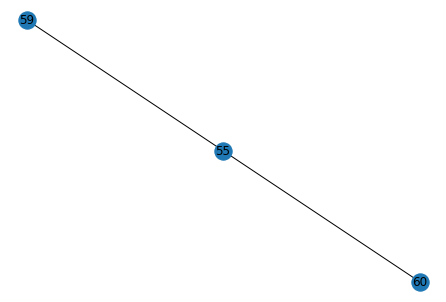

match_branches = [[59, 60]]
edges_to_delete (resolve crossover) = [[55, 59], [55, 60]]
edges_to_create (resolve crossover) = [[59, 60]]
edges_to_delete (cut_limb_network) = [array([55, 59]), array([55, 60])]
edges_to_create = [[59, 60]]
Number of connected components = 2
Comp 0 = {11, 52, 55, 56, 24}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154}
curr_limb_copy.deleted_edges = [array([55, 

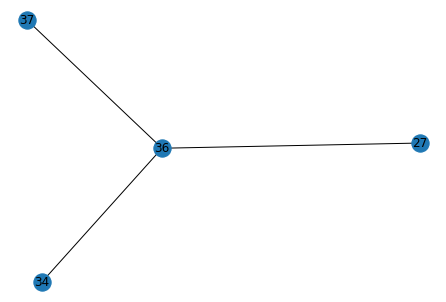

match_branches = [[34, 36], [27, 37]]
edges_to_delete (resolve crossover) = [[27, 34], [27, 36], [34, 37], [36, 37]]
edges_to_create (resolve crossover) = [[34, 36], [27, 37]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 35 because skeletal distance was 553.6350021805599 and threshold was 2500
Skipping endnode 44 because skeletal distance was 1770.7928337290616 and threshold was 2500
skip_nodes = [35, 44]
edges_to_delete (cut_limb_network) = [[27, 34], [27, 36], [34, 37], [36, 37]]
edges_to_create = [[34, 36], [27, 37]]
Number of connected components = 2
Comp 0 = {0, 9, 12, 18, 34, 36, 38, 39, 40, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57}
Comp 1 = {1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 41, 42, 45, 46}
curr_limb_copy.deleted_edges = [[27, 34], [27, 36], [34, 37], [36, 37]]
curr_limb_copy.created_edges = [[34, 36], [27, 37]]
After get best cut: cut_edges = [[27, 34], [27, 36], [34, 37], [36, 37]

  Edge: [1 3]: curr_angle = 40.47
  Edge: [3 2]: curr_angle = 122.96

Total time for doubling_back = 0.20033669471740723
There were 1 edges that passed doubling back threshold of 100
Winning edge [3 2] had a doubling back of 122.96257947126905
***inside resolve crossover!!!!****
coordinate_branches = [2, 3, 5]
2 = red
3 = aqua
5 = purple
Angle between 2 and 3 = 129.8 
Angle between 2 and 5 = 18.24 
Angle between 3 and 5 = 39.52 
Final Matches = [[2, 5]]
matched_branches_revised = [[2, 5]]
Original graph


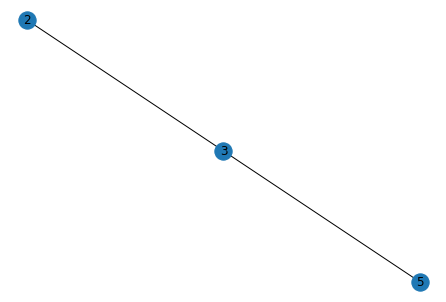

match_branches = [[2, 5]]
edges_to_delete (resolve crossover) = [[2, 3], [3, 5]]
edges_to_create (resolve crossover) = [[2, 5]]
edges_to_delete (cut_limb_network) = [array([2, 3]), array([3, 5])]
edges_to_create = [[2, 5]]
Number of connected components = 2
Comp 0 = {0, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83}
Comp 1 = {1, 3, 4, 16, 17}
curr_limb_copy.deleted_edges = [array([2, 3]), array([3, 5])]
curr_limb_copy.created_edges = [[2, 5]]
After get best cut: cut_edges = [array([2, 3]), array([3, 5])], added_edges = [[2, 5]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIR

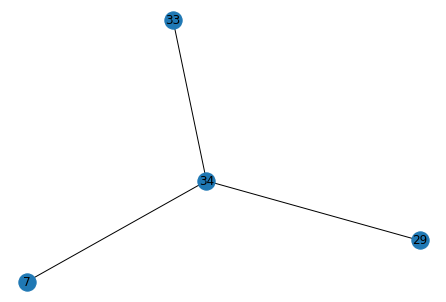

match_branches = [[33, 34]]
edges_to_delete (resolve crossover) = [[7, 29], [7, 33], [7, 34], [29, 33], [29, 34]]
edges_to_create (resolve crossover) = [[33, 34]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 30 because skeletal distance was 1185.3846175574056 and threshold was 2500
skip_nodes = [30]
edges_to_delete (cut_limb_network) = [[7, 29], [7, 33], [7, 34], [29, 33], [29, 34]]
edges_to_create = [[33, 34]]
Number of connected components = 4
Comp 0 = {28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52}
Comp 1 = {7}
Comp 2 = {0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29}
Comp 3 = {32}
curr_limb_copy.deleted_edges = [[7, 29], [7, 33], [7, 34], [29, 33], [29, 34]]
curr_limb_copy.created_edges = [[33, 34]]
After get best cut: cut_edges = [[7, 29], [7, 33], [7, 34], [29, 33], [29, 34]], added_edges = [[33, 34]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 

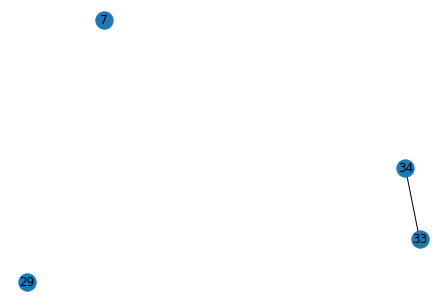

match_branches = [[33, 34]]
edges_to_delete (resolve crossover) = [[7, 29], [7, 33], [7, 34], [29, 33], [29, 34]]
edges_to_create (resolve crossover) = [[33, 34]]
curr_limb.deleted_edges 5 =[[7, 29], [7, 33], [7, 34], [29, 33], [29, 34]]
Skipping endnode 30 because skeletal distance was 1185.3846175574056 and threshold was 2500
skip_nodes = [30]
edges_to_delete (cut_limb_network) = [[7, 29], [7, 33], [7, 34], [29, 33], [29, 34]]
edges_to_create = [[33, 34]]
Number of connected components = 4
Comp 0 = {28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52}
Comp 1 = {7}
Comp 2 = {0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29}
Comp 3 = {32}
curr_limb_copy.deleted_edges = [[7, 29], [7, 33], [7, 34], [29, 33], [29, 34], [7, 29], [7, 33], [7, 34], [29, 33], [29, 34]]
curr_limb_copy.created_edges = [[33, 34], [33, 34]]
After get best cut: cut_edges = [[7, 29], [7, 33], [7, 34], [29, 33], [29, 34]], ad

  Edge: [31 37]: curr_angle = 65.03
  Edge: [37 34]: curr_angle = 134.99
  Edge: [34 33]: curr_angle = 39.37

Total time for doubling_back = 0.15306448936462402
There were 1 edges that passed doubling back threshold of 100
Winning edge [37 34] had a doubling back of 134.9930726635038
***inside resolve crossover!!!!****
coordinate_branches = [34, 36, 37]
34 = red
36 = aqua
37 = purple
Angle between 34 and 36 = 7.28 
Angle between 34 and 37 = 146.7 
Angle between 36 and 37 = 39.78 
Final Matches = [[34, 36]]
matched_branches_revised = [[34, 36]]
Original graph


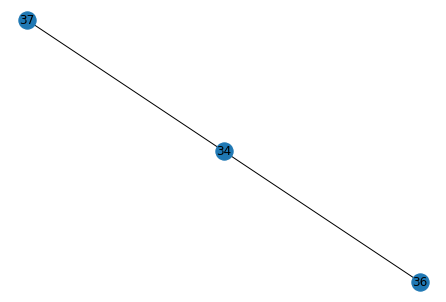

match_branches = [[34, 36]]
edges_to_delete (resolve crossover) = [[34, 37], [36, 37]]
edges_to_create (resolve crossover) = [[34, 36]]
edges_to_delete (cut_limb_network) = [array([34, 37]), array([36, 37])]
edges_to_create = [[34, 36]]
Number of connected components = 5
Comp 0 = {33, 34, 35, 36, 38, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52}
Comp 1 = {7}
Comp 2 = {0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29}
Comp 3 = {37, 39, 40, 41, 28, 30, 31}
Comp 4 = {32}
curr_limb_copy.deleted_edges = [[7, 29], [7, 33], [7, 34], [29, 33], [29, 34], [7, 29], [7, 33], [7, 34], [29, 33], [29, 34], array([34, 37]), array([36, 37])]
curr_limb_copy.created_edges = [[33, 34], [33, 34], [34, 36]]
After get best cut: cut_edges = [array([34, 37]), array([36, 37])], added_edges = [[34, 36]]
total_soma_paths_to_cut = [[7, 29], [7, 33], [7, 34], [29, 33], [29, 34]]
-----------counter = 1------------
 Cut iteration 2
Total number of graphs at the end o

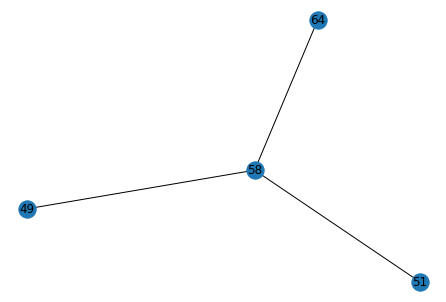

match_branches = []
edges_to_delete (resolve crossover) = [[49, 51], [49, 58], [49, 64], [51, 58], [51, 64], [58, 64]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[49, 51], [49, 58], [49, 64], [51, 58], [51, 64], [58, 64]]
edges_to_create = []
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 31, 34, 35, 37, 41, 44, 45, 58}
Comp 1 = {49}
Comp 2 = {21, 26, 29, 30, 32, 33, 36, 38, 39, 40, 42, 43, 46, 48, 50, 51, 53, 56, 62, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144}
Comp 3 = {64, 65, 66, 67, 68, 69, 70, 71.0, 74, 47, 52, 54, 55, 57,

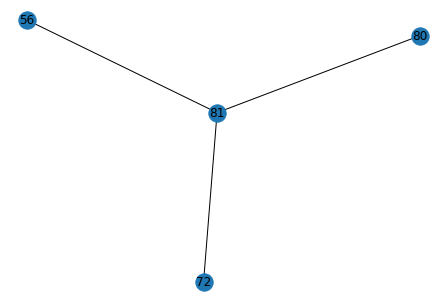

match_branches = [[56, 81], [72, 80]]
edges_to_delete (resolve crossover) = [[56, 72], [56, 80], [72, 81], [80, 81]]
edges_to_create (resolve crossover) = [[56, 81], [72, 80]]
curr_limb.deleted_edges 5 =[[49, 51], [49, 58], [49, 64], [51, 58], [51, 64], [58, 64]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[56, 72], [56, 80], [72, 81], [80, 81]]
edges_to_create = [[56, 81], [72, 80]]
Number of connected components = 6
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 31, 34, 35, 37, 41, 44, 45, 58}
Comp 1 = {49}
Comp 2 = {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 32, 33, 36, 38, 39, 40, 42, 43, 48, 50, 51, 53, 56, 62, 76, 78, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
Comp 3 = {64, 65, 66, 67, 68, 69, 70, 71.0, 74,

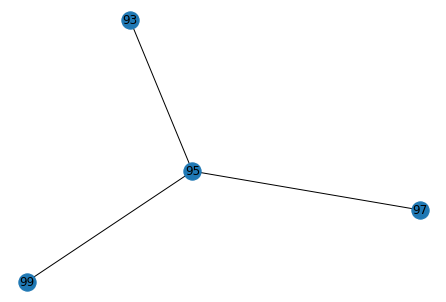

match_branches = []
edges_to_delete (resolve crossover) = [[93, 95], [93, 97], [93, 99], [95, 97], [95, 99], [97, 99]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[[49, 51], [49, 58], [49, 64], [51, 58], [51, 64], [58, 64], [56, 72], [56, 80], [72, 81], [80, 81]]
Skipping endnode 97 because skeletal distance was 1862.0386004263194 and threshold was 2500
skip_nodes = [97]
edges_to_delete (cut_limb_network) = [[93, 95], [93, 97], [93, 99], [95, 97], [95, 99], [97, 99]]
edges_to_create = []
Number of connected components = 9
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 31, 34, 35, 37, 41, 44, 45, 58}
Comp 1 = {49}
Comp 2 = {128, 129, 130, 143, 144, 32, 33, 36, 38, 39, 42, 43, 48, 50, 51, 53, 56, 76, 78, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 114, 117, 120, 123, 124, 125}
Comp 3 = {64, 65, 66, 67, 68, 69, 70, 71.0, 74, 47, 52, 54, 55, 57, 59, 60, 61, 63}
Comp 4 = {72, 73, 75, 77, 46, 79, 80,

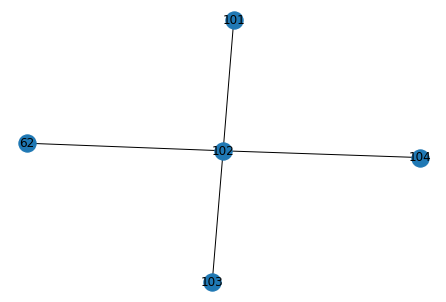

match_branches = [[101, 102]]
edges_to_delete (resolve crossover) = [[62, 101], [62, 102], [62, 103], [62, 104], [101, 103], [101, 104], [102, 103], [102, 104], [103, 104]]
edges_to_create (resolve crossover) = [[101, 102]]
curr_limb.deleted_edges 5 =[[49, 51], [49, 58], [49, 64], [51, 58], [51, 64], [58, 64], [56, 72], [56, 80], [72, 81], [80, 81], [93, 95], [93, 97], [93, 99], [95, 97], [95, 99], [97, 99]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[62, 101], [62, 102], [62, 103], [62, 104], [101, 103], [101, 104], [102, 103], [102, 104], [103, 104]]
edges_to_create = [[101, 102]]
Number of connected components = 11
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 31, 34, 35, 37, 41, 44, 45, 58}
Comp 1 = {49}
Comp 2 = {128, 129, 130, 143, 144, 32, 33, 36, 38, 39, 42, 43, 48, 50, 51, 53, 56, 76, 78, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 114, 117, 120, 123, 124, 125}
Comp 3 = {64, 65, 66, 67, 68, 69, 70

  Edge: [ 98 108]: curr_angle = 53.7
  Edge: [108 115]: curr_angle = 28.76
  Edge: [115 133]: curr_angle = 28.65
  Edge: [133 136]: curr_angle = 91.45
  Edge: [136 118]: curr_angle = 125.32
  Edge: [118 116]: curr_angle = 45.26
  Edge: [116 110]: curr_angle = 71.98
  Edge: [110 105]: curr_angle = 60.24

Total time for doubling_back = 0.5283489227294922
There were 1 edges that passed doubling back threshold of 100
Winning edge [136 118] had a doubling back of 125.32203613110939
***inside resolve crossover!!!!****
coordinate_branches = [118, 135, 136]
118 = red
135 = aqua
136 = purple
Angle between 118 and 135 = 32.85 
Angle between 118 and 136 = 67.16 
Angle between 135 and 136 = 81.18 
Final Matches = [[118, 135]]
matched_branches_revised = [[118, 135]]
Original graph


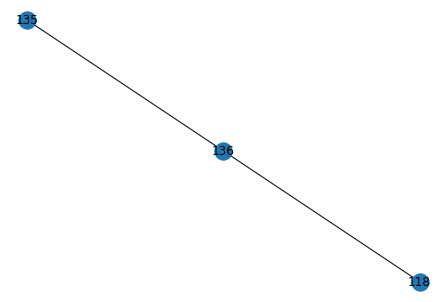

match_branches = [[118, 135]]
edges_to_delete (resolve crossover) = [[118, 136], [135, 136]]
edges_to_create (resolve crossover) = [[118, 135]]
edges_to_delete (cut_limb_network) = [array([118, 136]), array([135, 136])]
edges_to_create = [[118, 135]]
Number of connected components = 12
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 31, 34, 35, 37, 41, 44, 45, 58}
Comp 1 = {49}
Comp 2 = {128, 129, 130, 143, 144, 32, 33, 36, 38, 39, 42, 43, 48, 50, 51, 53, 56, 76, 78, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 114, 117, 120, 123, 124, 125}
Comp 3 = {64, 65, 66, 67, 68, 69, 70, 71.0, 74, 47, 52, 54, 55, 57, 59, 60, 61, 63}
Comp 4 = {72, 73, 75, 77, 46, 79, 80, 82, 21, 26, 29, 30}
Comp 5 = {93}
Comp 6 = {97}
Comp 7 = {133, 134, 136, 139, 140, 141, 142, 40, 98, 99, 100, 101, 102, 106, 107, 108, 111, 112, 113, 115, 121, 122}
Comp 8 = {131, 132, 135, 103, 137, 138, 105, 109, 110, 116, 118, 119, 126, 127}
Comp 9 = {62}
Comp 

  Edge: [5 7]: curr_angle = 61.65
  Edge: [ 7 11]: curr_angle = 53.09
  Edge: [11 10]: curr_angle = 160.08
  Edge: [10  8]: curr_angle = 44.22

Total time for doubling_back = 0.18474745750427246
There were 1 edges that passed doubling back threshold of 100
Winning edge [11 10] had a doubling back of 160.07695899764192
***inside resolve crossover!!!!****
coordinate_branches = [10, 11, 14]
10 = red
11 = aqua
14 = purple
Angle between 10 and 11 = 145.79 
Angle between 10 and 14 = 16.78 
Angle between 11 and 14 = 34.28 
Final Matches = [[10, 14], [11, 14]]
matched_branches_revised = [[10, 14]]
Original graph


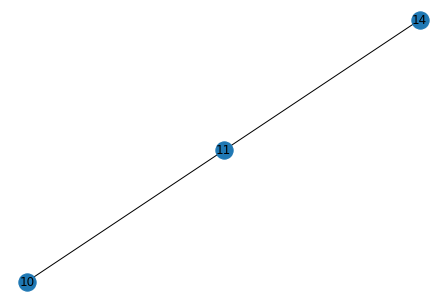

match_branches = [[10, 14]]
edges_to_delete (resolve crossover) = [[10, 11], [11, 14]]
edges_to_create (resolve crossover) = [[10, 14]]
edges_to_delete (cut_limb_network) = [array([10, 11]), array([11, 14])]
edges_to_create = [[10, 14]]
Number of connected components = 2
Comp 0 = {0, 1, 3, 6, 8, 9, 10, 12, 13, 14, 15, 16}
Comp 1 = {2, 4, 5, 7, 11}
curr_limb_copy.deleted_edges = [array([10, 11]), array([11, 14])]
curr_limb_copy.created_edges = [[10, 14]]
After get best cut: cut_edges = [array([10, 11]), array([11, 14])], added_edges = [[10, 14]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  3,  6,  8,  9, 10, 12, 13, 14, 15, 16]), array([ 2,  4,  5,  7, 11])]


 ------ Total time for Splitting 864691

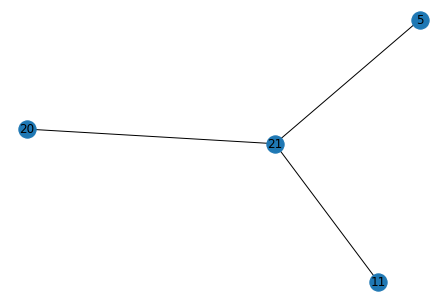

match_branches = [[11, 20], [5, 21]]
edges_to_delete (resolve crossover) = [[5, 11], [5, 20], [11, 21], [20, 21]]
edges_to_create (resolve crossover) = [[11, 20], [5, 21]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[5, 11], [5, 20], [11, 21], [20, 21]]
edges_to_create = [[11, 20], [5, 21]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 4, 7, 8, 9, 10.0, 11, 12, 13, 14.0, 15, 20, 22, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 41, 50, 51, 53, 54, 55, 56, 61, 64, 65, 66, 68, 69, 70, 71, 72, 73.0, 74, 75, 76, 77, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95.0, 96}
Comp 1 = {3, 5, 6, 16, 17, 18, 21, 23, 30, 31, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 52, 57, 58, 59, 60, 62, 67, 78, 79, 80, 91, 92}
Comp 2 = {19}
Comp 3 = {63}
curr_limb_copy.deleted_edges = [[5, 11], [5, 20], [11, 21], [20, 21]]
curr_limb_copy.created_edges = [[11, 20], [5, 21]]
After get best cut: cut_edges = [[5, 11], [5, 20], [11, 21], [20, 21]], added_edges = 

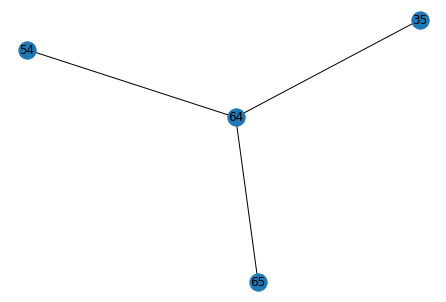

match_branches = [[54, 64]]
edges_to_delete (resolve crossover) = [[35, 54], [35, 64], [35, 65], [54, 65], [64, 65]]
edges_to_create (resolve crossover) = [[54, 64]]
curr_limb.deleted_edges 5 =[[5, 11], [5, 20], [11, 21], [20, 21]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[35, 54], [35, 64], [35, 65], [54, 65], [64, 65]]
edges_to_create = [[54, 64]]
Number of connected components = 6
Comp 0 = {0, 1, 2, 4, 7, 8, 9, 10.0, 11, 12, 13, 14.0, 15, 20, 22, 24, 25, 26, 27, 28, 29, 32, 33, 34, 36, 37, 38, 41, 50, 51, 53, 54, 55, 56, 61, 64, 66, 68, 69, 70, 71, 72, 73.0, 74, 75, 76, 77, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95.0, 96}
Comp 1 = {35}
Comp 2 = {65}
Comp 3 = {3, 5, 6, 16, 17, 18, 21, 23, 30, 31, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 52, 57, 58, 59, 60, 62, 67, 78, 79, 80, 91, 92}
Comp 4 = {19}
Comp 5 = {63}
curr_limb_copy.deleted_edges = [[5, 11], [5, 20], [11, 21], [20, 21], [35, 54], [35, 64], [35, 65], [54, 65], [64, 65]]
curr_limb_copy.created_edges = [[1

  Edge: [66 64]: curr_angle = 27.58
  Edge: [64 54]: curr_angle = 10.41
  Edge: [54 51]: curr_angle = 32.38
  Edge: [51 50]: curr_angle = 9.81
  Edge: [50 53]: curr_angle = 6.89
  Edge: [53 55]: curr_angle = 26.21
  Edge: [55 61]: curr_angle = 42.52
  Edge: [61 82]: curr_angle = 40.99
  Edge: [82 81]: curr_angle = 45.23
  Edge: [81 83]: curr_angle = 38.54
  Edge: [83 90]: curr_angle = 34.72
  Edge: [90 93]: curr_angle = 26.17

Total time for doubling_back = 2.05181622505188

Attempting the width jump check (attempting from both sides)
  Edge: [66 64]: jump = -200.57
  Edge: [64 54]: jump = 24.37
  Edge: [54 51]: jump = 20.56
  Edge: [51 50]: jump = -100.38
  Edge: [50 53]: jump = -137.71
  Edge: [53 55]: jump = -175.89
  Edge: [55 61]: jump = -317.42
  Edge: [61 82]: jump = -67.93
  Edge: [82 81]: jump = 56.29
  Edge: [81 83]: jump = 55.56
  Edge: [83 90]: jump = 88.2
  Edge: [90 93]: jump = 184.4
Total time for width = 2.009498357772827
Path starting at 66 had err_edges: []
  Edge: [9

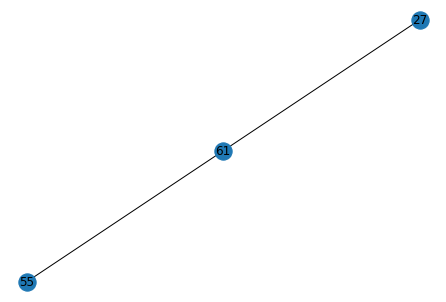

match_branches = [[27, 55]]
edges_to_delete (resolve crossover) = [[27, 61], [55, 61]]
edges_to_create (resolve crossover) = [[27, 55]]
edges_to_delete (cut_limb_network) = [array([27, 61]), array([55, 61])]
edges_to_create = [[27, 55]]
Number of connected components = 7
Comp 0 = {0, 1, 4, 7, 8, 9, 10.0, 11, 12, 13, 14.0, 15, 20, 22, 24, 25, 27, 28, 29, 32, 33, 34, 36, 37, 38, 41, 50, 51, 53, 54, 55, 64, 66, 68, 69, 70, 71, 72, 73.0, 84, 85, 88, 89, 94, 95.0, 96}
Comp 1 = {35}
Comp 2 = {65}
Comp 3 = {2, 26, 74, 75, 76, 77, 81, 82, 83, 93, 86, 87, 56, 90, 61}
Comp 4 = {3, 5, 6, 16, 17, 18, 21, 23, 30, 31, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 52, 57, 58, 59, 60, 62, 67, 78, 79, 80, 91, 92}
Comp 5 = {19}
Comp 6 = {63}
curr_limb_copy.deleted_edges = [[5, 11], [5, 20], [11, 21], [20, 21], [35, 54], [35, 64], [35, 65], [54, 65], [64, 65], array([27, 61]), array([55, 61])]
curr_limb_copy.created_edges = [[11, 20], [5, 21], [54, 64], [27, 55]]
After get best cut: cut_edges = [array([27, 61]

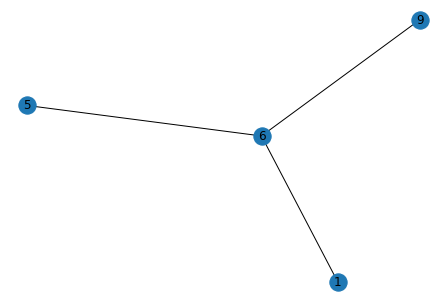

match_branches = [[1, 9]]
edges_to_delete (resolve crossover) = [[1, 5], [1, 6], [5, 6], [5, 9], [6, 9]]
edges_to_create (resolve crossover) = [[1, 9]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 5], [1, 6], [5, 6], [5, 9], [6, 9]]
edges_to_create = [[1, 9]]
Number of connected components = 3
Comp 0 = {0, 1, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}
Comp 1 = {5}
Comp 2 = {2, 3, 4, 6, 8}
curr_limb_copy.deleted_edges = [[1, 5], [1, 6], [5, 6], [5, 9], [6, 9]]
curr_limb_copy.created_edges = [[1, 9]]
After get best cut: cut_edges = [[1, 5], [1, 6], [5, 6], [5, 9], [6, 9]], added_edges = [[1, 9]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next con

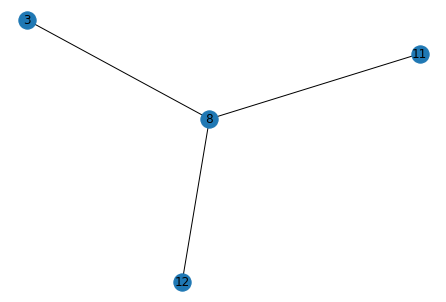

match_branches = [[8, 12]]
edges_to_delete (resolve crossover) = [[3, 8], [3, 11], [3, 12], [8, 11], [11, 12]]
edges_to_create (resolve crossover) = [[8, 12]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[3, 8], [3, 11], [3, 12], [8, 11], [11, 12]]
edges_to_create = [[8, 12]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 7}
Comp 1 = {6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
Comp 2 = {11}
curr_limb_copy.deleted_edges = [[3, 8], [3, 11], [3, 12], [8, 11], [11, 12]]
curr_limb_copy.created_edges = [[8, 12]]
After get best cut: cut_edges = [[3, 8], [3, 11], [3, 12], [8, 11], [11, 12]], added_edges = [[8, 12]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 7 and 22
---- T

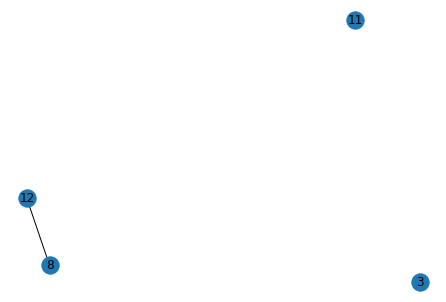

match_branches = [[8, 12]]
edges_to_delete (resolve crossover) = [[3, 8], [3, 11], [3, 12], [8, 11], [11, 12]]
edges_to_create (resolve crossover) = [[8, 12]]
curr_limb.deleted_edges 5 =[[3, 8], [3, 11], [3, 12], [8, 11], [11, 12]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[3, 8], [3, 11], [3, 12], [8, 11], [11, 12]]
edges_to_create = [[8, 12]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 7}
Comp 1 = {6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
Comp 2 = {11}
curr_limb_copy.deleted_edges = [[3, 8], [3, 11], [3, 12], [8, 11], [11, 12], [3, 8], [3, 11], [3, 12], [8, 11], [11, 12]]
curr_limb_copy.created_edges = [[8, 12], [8, 12]]
After get best cut: cut_edges = [[3, 8], [3, 11], [3, 12], [8, 11], [11, 12]], added_edges = [[8, 12]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3

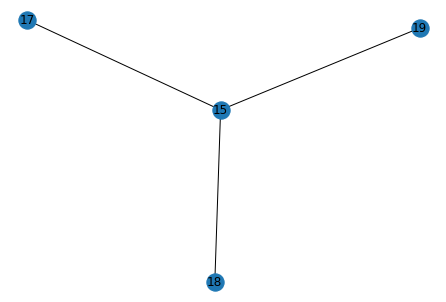

match_branches = [[17, 19], [15, 18]]
edges_to_delete (resolve crossover) = [[15, 17], [15, 19], [17, 18], [18, 19]]
edges_to_create (resolve crossover) = [[17, 19], [15, 18]]
curr_limb.deleted_edges 5 =[[3, 8], [3, 11], [3, 12], [8, 11], [11, 12], [3, 8], [3, 11], [3, 12], [8, 11], [11, 12]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[15, 17], [15, 19], [17, 18], [18, 19]]
edges_to_create = [[17, 19], [15, 18]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 7}
Comp 1 = {8, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21}
Comp 2 = {11}
Comp 3 = {17, 19, 6, 22}
curr_limb_copy.deleted_edges = [[3, 8], [3, 11], [3, 12], [8, 11], [11, 12], [3, 8], [3, 11], [3, 12], [8, 11], [11, 12], [15, 17], [15, 19], [17, 18], [18, 19]]
curr_limb_copy.created_edges = [[8, 12], [8, 12], [17, 19], [15, 18]]
After get best cut: cut_edges = [[15, 17], [15, 19], [17, 18], [18, 19]], added_edges = [[17, 19], [15, 18]]
total_soma_paths_to_cut = [[3, 8], [3, 11], [3, 12], [8, 11], [11, 12]]
---

  Edge: [0 2]: curr_angle = 25.77
  Edge: [2 4]: curr_angle = 29.61
  Edge: [4 8]: curr_angle = 166.95
  Edge: [ 8 19]: curr_angle = 25.76
  Edge: [19 13]: curr_angle = 61.1

Total time for doubling_back = 0.38449788093566895
There were 1 edges that passed doubling back threshold of 100
Winning edge [4 8] had a doubling back of 166.94532058086986
***inside resolve crossover!!!!****
coordinate_branches = [4, 8, 9]
4 = red
8 = aqua
9 = purple
Angle between 4 and 8 = 158.16 
Angle between 4 and 9 = 25.61 
Angle between 8 and 9 = 26.12 
Final Matches = [[4, 9], [8, 9]]
matched_branches_revised = [[4, 9]]
Original graph


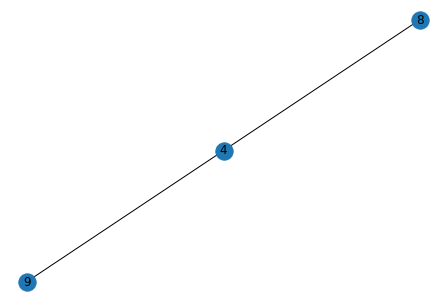

match_branches = [[4, 9]]
edges_to_delete (resolve crossover) = [[4, 8], [8, 9]]
edges_to_create (resolve crossover) = [[4, 9]]
edges_to_delete (cut_limb_network) = [array([4, 8]), array([8, 9])]
edges_to_create = [[4, 9]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26}
Comp 1 = {8, 13, 18, 19, 20, 27, 28, 29, 30}
curr_limb_copy.deleted_edges = [array([4, 8]), array([8, 9])]
curr_limb_copy.created_edges = [[4, 9]]
After get best cut: cut_edges = [array([4, 8]), array([8, 9])], added_edges = [[4, 9]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection


---- working on disconnecting 0 and 16
---- This disconnects S0_0 from S1_1  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE

  Edge: [0 3]: curr_angle = 57.03
  Edge: [ 3 22]: curr_angle = 109.22
  Edge: [22 21]: curr_angle = 85.56
  Edge: [21 16]: curr_angle = 79.06

Total time for doubling_back = 0.18902802467346191
There were 1 edges that passed doubling back threshold of 100
Winning edge [ 3 22] had a doubling back of 109.22351946142332
***inside resolve crossover!!!!****
coordinate_branches = [3, 22, 23]
3 = red
22 = aqua
23 = purple
Angle between 3 and 22 = 149.31 
Angle between 3 and 23 = 16.65 
Angle between 22 and 23 = 40.53 
Final Matches = [[3, 23]]
matched_branches_revised = [[3, 23]]
Original graph


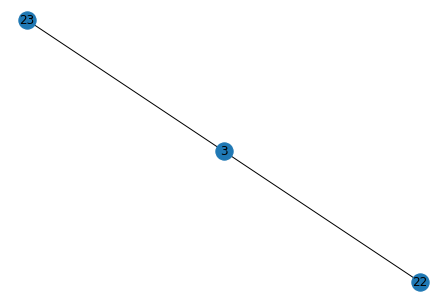

match_branches = [[3, 23]]
edges_to_delete (resolve crossover) = [[3, 22], [22, 23]]
edges_to_create (resolve crossover) = [[3, 23]]
edges_to_delete (cut_limb_network) = [array([ 3, 22]), array([22, 23])]
edges_to_create = [[3, 23]]
Number of connected components = 3
Comp 0 = {0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 17, 23, 25, 26}
Comp 1 = {1, 16, 21, 22, 24}
Comp 2 = {8, 13, 18, 19, 20, 27, 28, 29, 30}
curr_limb_copy.deleted_edges = [array([4, 8]), array([8, 9]), array([ 3, 22]), array([22, 23])]
curr_limb_copy.created_edges = [[4, 9], [3, 23]]
After get best cut: cut_edges = [array([ 3, 22]), array([22, 23])], added_edges = [[3, 23]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 13 and 16
---- This disconnects S1_0 from S1_1  
 

  Edge: [36 35]: curr_angle = 46.37
  Edge: [35 16]: curr_angle = 40.83
  Edge: [16 12]: curr_angle = 68.93
  Edge: [12 14]: curr_angle = 113.46
  Edge: [14 31]: curr_angle = 27.88
  Edge: [31 34]: curr_angle = 48.71
  Edge: [34 37]: curr_angle = 17.59

Total time for doubling_back = 0.8061227798461914
There were 1 edges that passed doubling back threshold of 100
Winning edge [12 14] had a doubling back of 113.46142877138026
***inside resolve crossover!!!!****
coordinate_branches = [2, 12, 14]
2 = red
12 = aqua
14 = purple
Angle between 2 and 12 = 41.63 
Angle between 2 and 14 = 10.82 
Angle between 12 and 14 = 137.72 
Final Matches = [[2, 14]]
matched_branches_revised = [[2, 14]]
Original graph


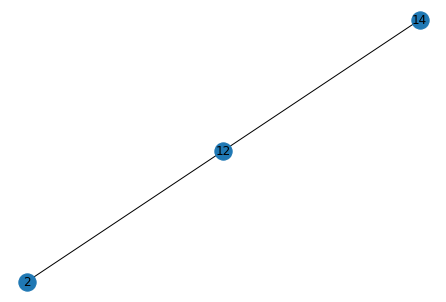

match_branches = [[2, 14]]
edges_to_delete (resolve crossover) = [[2, 12], [12, 14]]
edges_to_create (resolve crossover) = [[2, 14]]
edges_to_delete (cut_limb_network) = [array([ 2, 12]), array([12, 14])]
edges_to_create = [[2, 14]]
Number of connected components = 2
Comp 0 = {2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38}
Comp 1 = {0, 1, 35, 36, 11, 12, 16}
curr_limb_copy.deleted_edges = [array([ 2, 12]), array([12, 14])]
curr_limb_copy.created_edges = [[2, 14]]
After get best cut: cut_edges = [array([ 2, 12]), array([12, 14])], added_edges = [[2, 14]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 13

  Edge: [12 17]: curr_angle = 26.08
  Edge: [17 15]: curr_angle = 48.65
  Edge: [15 26]: curr_angle = 169.82
  Edge: [26 23]: curr_angle = 75.78

Total time for doubling_back = 0.7421257495880127
There were 1 edges that passed doubling back threshold of 100
Winning edge [15 26] had a doubling back of 169.81690778493643
***inside resolve crossover!!!!****
coordinate_branches = [15, 26, 30]
15 = red
26 = aqua
30 = purple
Angle between 15 and 26 = 169.38 
Angle between 15 and 30 = 29.36 
Angle between 26 and 30 = 19.13 
Final Matches = [[15, 30], [26, 30]]
matched_branches_revised = [[26, 30]]
Original graph


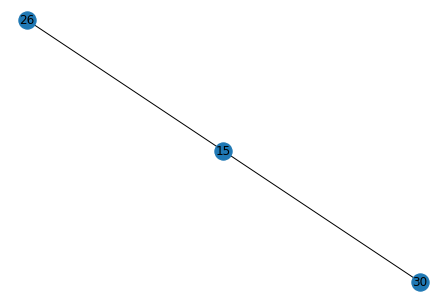

match_branches = [[26, 30]]
edges_to_delete (resolve crossover) = [[15, 26], [15, 30]]
edges_to_create (resolve crossover) = [[26, 30]]
edges_to_delete (cut_limb_network) = [array([15, 26]), array([15, 30])]
edges_to_create = [[26, 30]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 33, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73}
Comp 1 = {32, 34, 37, 38, 12, 15, 17, 18, 19, 28, 31}
curr_limb_copy.deleted_edges = [array([15, 26]), array([15, 30])]
curr_limb_copy.created_edges = [[26, 30]]
After get best cut: cut_edges = [array([15, 26]), array([15, 30])], added_edges = [[26, 30]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
N

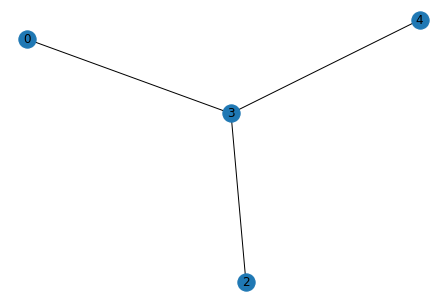

match_branches = [[0, 4]]
edges_to_delete (resolve crossover) = [[0, 2], [0, 3], [2, 3], [2, 4], [3, 4]]
edges_to_create (resolve crossover) = [[0, 4]]
curr_limb.deleted_edges 5 =[array([15, 26]), array([15, 30])]
Skipping endnode 55 because skeletal distance was 2255.558831131166 and threshold was 2500
skip_nodes = [55]
edges_to_delete (cut_limb_network) = [[0, 2], [0, 3], [2, 3], [2, 4], [3, 4]]
edges_to_create = [[0, 4]]
Number of connected components = 4
Comp 0 = {0, 4, 5, 6, 33, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73}
Comp 1 = {2}
Comp 2 = {1, 3, 7, 8, 9, 10, 11, 13, 14, 16, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 35, 36}
Comp 3 = {32, 34, 37, 38, 12, 15, 17, 18, 19, 28, 31}
curr_limb_copy.deleted_edges = [array([15, 26]), array([15, 30]), [0, 2], [0, 3], [2, 3], [2, 4], [3, 4]]
curr_limb_copy.created_edges = [[26, 30], [0, 4]]
After get best cut: cut_edges = [[0, 2], [0, 3], [2, 3]

  Edge: [2 5]: curr_angle = 44.59
  Edge: [5 1]: curr_angle = 81.97
  Edge: [1 3]: curr_angle = 34.51
  Edge: [3 7]: curr_angle = 29.84

Total time for doubling_back = 0.2376854419708252

Attempting the width jump check (attempting from both sides)
  Edge: [2 5]: jump = -174.66
  Edge: [5 1]: jump = -168.84
  Edge: [1 3]: jump = 74.46
  Edge: [3 7]: jump = 143.08
Total time for width = 0.19800734519958496
Path starting at 2 had err_edges: []
  Edge: [7 3]: jump = -143.08
  Edge: [3 1]: jump = -74.46
  Edge: [1 5]: jump = 168.84
  Edge: [5 2]: jump = 174.66
Total time for width = 0.19634532928466797
Path starting at 7 had err_edges: []
Did not find an error edge in either of the paths
Number of connected components = 1
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
curr_limb_copy.deleted_edges = []
curr_limb_copy.created_edges = []
After get best cut: cut_edges = None, added_edges = []
***** there was no suggested cut for this limb even though it is still connnected

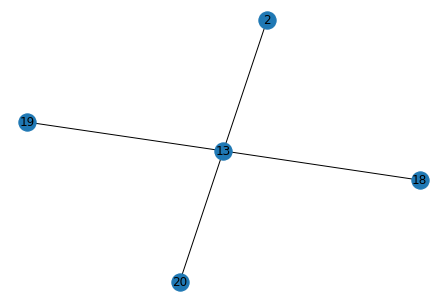

match_branches = [[13, 18]]
edges_to_delete (resolve crossover) = [[2, 13], [2, 18], [2, 19], [2, 20], [13, 19], [13, 20], [18, 19], [18, 20], [19, 20]]
edges_to_create (resolve crossover) = [[13, 18]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[2, 13], [2, 18], [2, 19], [2, 20], [13, 19], [13, 20], [18, 19], [18, 20], [19, 20]]
edges_to_create = [[13, 18]]
Number of connected components = 3
Comp 0 = {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114}
Comp 1 = {2}
Comp 2 = {19}
curr_limb_copy.deleted_edges = [[2, 13], [2, 18], [2, 19], [2, 20], [

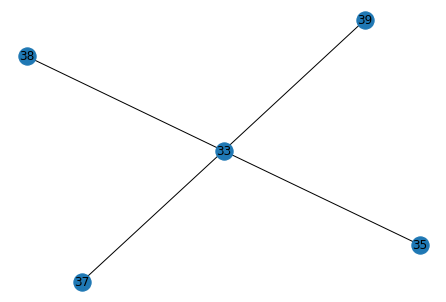

match_branches = [[33, 38], [35, 37]]
edges_to_delete (resolve crossover) = [[33, 35], [33, 37], [33, 39], [35, 38], [35, 39], [37, 38], [37, 39], [38, 39]]
edges_to_create (resolve crossover) = [[33, 38], [35, 37]]
curr_limb.deleted_edges 5 =[[2, 13], [2, 18], [2, 19], [2, 20], [13, 19], [13, 20], [18, 19], [18, 20], [19, 20]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[33, 35], [33, 37], [33, 39], [35, 38], [35, 39], [37, 38], [37, 39], [38, 39]]
edges_to_create = [[33, 38], [35, 37]]
Number of connected components = 5
Comp 0 = {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 31, 32, 35, 36, 37, 40, 41, 46, 47, 53, 54}
Comp 1 = {2}
Comp 2 = {19}
Comp 3 = {20, 21, 24, 25, 26, 27, 28, 29, 30, 33, 34, 38, 42, 43, 44, 45, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 1

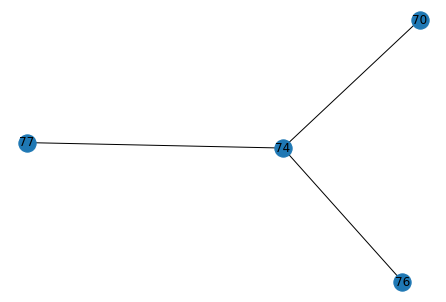

match_branches = [[74, 76], [70, 77]]
edges_to_delete (resolve crossover) = [[70, 74], [70, 76], [74, 77], [76, 77]]
edges_to_create (resolve crossover) = [[74, 76], [70, 77]]
curr_limb.deleted_edges 5 =[[2, 13], [2, 18], [2, 19], [2, 20], [13, 19], [13, 20], [18, 19], [18, 20], [19, 20], [33, 35], [33, 37], [33, 39], [35, 38], [35, 39], [37, 38], [37, 39], [38, 39]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[70, 74], [70, 76], [74, 77], [76, 77]]
edges_to_create = [[74, 76], [70, 77]]
Number of connected components = 7
Comp 0 = {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 31, 32, 35, 36, 37, 40, 41, 46, 47, 53, 54}
Comp 1 = {2}
Comp 2 = {19}
Comp 3 = {20, 21, 24, 25, 26, 27, 28, 29, 30, 33, 34, 38, 42, 43, 44, 45, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 1

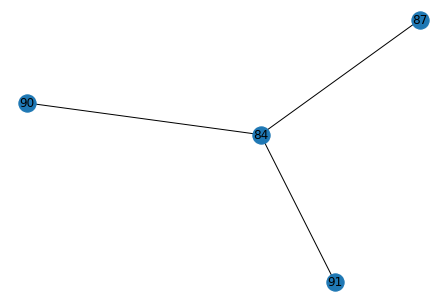

match_branches = [[84, 87]]
edges_to_delete (resolve crossover) = [[84, 90], [84, 91], [87, 90], [87, 91], [90, 91]]
edges_to_create (resolve crossover) = [[84, 87]]
curr_limb.deleted_edges 5 =[[2, 13], [2, 18], [2, 19], [2, 20], [13, 19], [13, 20], [18, 19], [18, 20], [19, 20], [33, 35], [33, 37], [33, 39], [35, 38], [35, 39], [37, 38], [37, 39], [38, 39], [70, 74], [70, 76], [74, 77], [76, 77]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[84, 90], [84, 91], [87, 90], [87, 91], [90, 91]]
edges_to_create = [[84, 87]]
Number of connected components = 9
Comp 0 = {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 31, 32, 35, 36, 37, 40, 41, 46, 47, 53, 54}
Comp 1 = {2}
Comp 2 = {19}
Comp 3 = {20, 21, 24, 25, 26, 27, 28, 29, 30, 33, 34, 38, 42, 43, 44, 45, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 92, 93, 100, 101}
Comp 4 = {39}
Comp 5 = {63, 77, 70, 71}
Comp 6 = {90

  Edge: [29 27]: curr_angle = 27.16
  Edge: [27 24]: curr_angle = 1.56
  Edge: [24 25]: curr_angle = 21.11
  Edge: [25 26]: curr_angle = 33.74
  Edge: [26 34]: curr_angle = 52.56
  Edge: [34 44]: curr_angle = 16.72
  Edge: [44 49]: curr_angle = 20.49
  Edge: [49 60]: curr_angle = 34.38
  Edge: [60 64]: curr_angle = 27.3
  Edge: [64 67]: curr_angle = 16.24
  Edge: [67 68]: curr_angle = 24.65
  Edge: [68 72]: curr_angle = 24.67
  Edge: [72 74]: curr_angle = 11.71
  Edge: [74 76]: curr_angle = 21.26
  Edge: [76 78]: curr_angle = 23.93
  Edge: [78 81]: curr_angle = 3.31
  Edge: [81 84]: curr_angle = 16.67
  Edge: [84 87]: curr_angle = 25.97

Total time for doubling_back = 2.078953266143799

Attempting the width jump check (attempting from both sides)
  Edge: [29 27]: jump = 8.03
  Edge: [27 24]: jump = -123.12
  Edge: [24 25]: jump = -103.5
  Edge: [25 26]: jump = -62.72
  Edge: [26 34]: jump = -386.99
  Edge: [34 44]: jump = 163.82
  Edge: [44 49]: jump = 136.39
  Edge: [49 60]: jump = 12

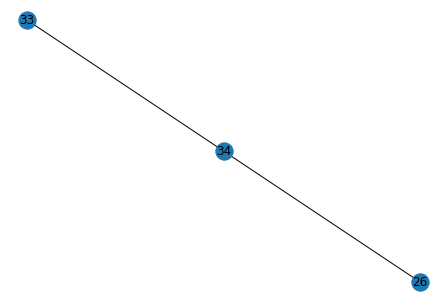

match_branches = [[26, 33]]
edges_to_delete (resolve crossover) = [[26, 34], [33, 34]]
edges_to_create (resolve crossover) = [[26, 33]]
edges_to_delete (cut_limb_network) = [array([26, 34]), array([33, 34])]
edges_to_create = [[26, 33]]
Number of connected components = 10
Comp 0 = {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 31, 32, 35, 36, 37, 40, 41, 46, 47, 53, 54}
Comp 1 = {2}
Comp 2 = {19}
Comp 3 = {33, 38, 20, 21, 24, 25, 26, 27, 28, 29, 30}
Comp 4 = {34, 42, 43, 44, 45, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 92, 93, 100, 101}
Comp 5 = {39}
Comp 6 = {63, 77, 70, 71}
Comp 7 = {90}
Comp 8 = {80, 91, 94, 95, 96, 97, 98, 99, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114}
Comp 9 = {89}
curr_limb_copy.deleted_edges = [[2, 13], [2, 18], [2, 19], [2, 20], [13, 19], [13, 20], [18, 19], [18, 20], [19, 20], [33, 35], [33, 37], [33, 39], [35, 38], [35,

  Edge: [10  7]: curr_angle = 10.53
  Edge: [7 6]: curr_angle = 123.43
  Edge: [ 6 16]: curr_angle = 28.2
  Edge: [16 24]: curr_angle = 40.29
  Edge: [24 26]: curr_angle = 10.5
  Edge: [26 29]: curr_angle = 31.82
  Edge: [29 31]: curr_angle = 22.79
  Edge: [31 37]: curr_angle = 35.08
  Edge: [37 32]: curr_angle = 32.54

Total time for doubling_back = 0.6727457046508789
There were 1 edges that passed doubling back threshold of 100
Winning edge [7 6] had a doubling back of 123.43477195325147
***inside resolve crossover!!!!****
coordinate_branches = [5, 6, 7]
5 = red
6 = aqua
7 = purple
Angle between 5 and 6 = 28.62 
Angle between 5 and 7 = 45.06 
Angle between 6 and 7 = 107.49 
Final Matches = [[5, 6]]
matched_branches_revised = [[5, 6]]
Original graph


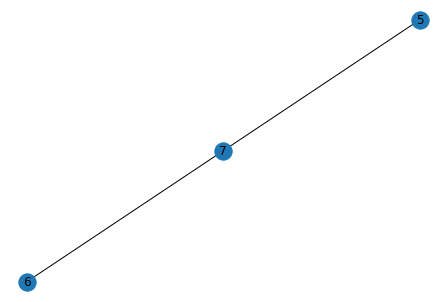

match_branches = [[5, 6]]
edges_to_delete (resolve crossover) = [[5, 7], [6, 7]]
edges_to_create (resolve crossover) = [[5, 6]]
edges_to_delete (cut_limb_network) = [array([5, 7]), array([6, 7])]
edges_to_create = [[5, 6]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}
Comp 1 = {9, 10, 7}
curr_limb_copy.deleted_edges = [array([5, 7]), array([6, 7])]
curr_limb_copy.created_edges = [[5, 6]]
After get best cut: cut_edges = [array([5, 7]), array([6, 7])], added_edges = [[5, 6]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  4,  5,  6

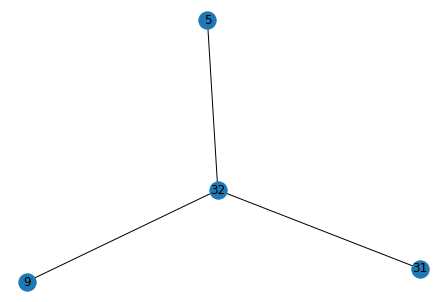

match_branches = [[5, 31], [9, 32]]
edges_to_delete (resolve crossover) = [[5, 9], [5, 32], [9, 31], [31, 32]]
edges_to_create (resolve crossover) = [[5, 31], [9, 32]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[5, 9], [5, 32], [9, 31], [31, 32]]
edges_to_create = [[5, 31], [9, 32]]
Number of connected components = 3
Comp 0 = {64, 5, 40, 57, 60, 49, 52, 21, 54, 24, 56, 25, 58, 59, 31, 61, 62, 63}
Comp 1 = {0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 53, 55}
Comp 2 = {30}
curr_limb_copy.deleted_edges = [[5, 9], [5, 32], [9, 31], [31, 32]]
curr_limb_copy.created_edges = [[5, 31], [9, 32]]
After get best cut: cut_edges = [[5, 9], [5, 32], [9, 31], [31, 32]], added_edges = [[5, 31], [9, 32]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRE

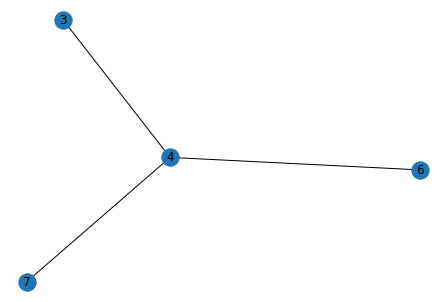

match_branches = [[4, 7]]
edges_to_delete (resolve crossover) = [[3, 4], [3, 6], [3, 7], [4, 6], [6, 7]]
edges_to_create (resolve crossover) = [[4, 7]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 4 because skeletal distance was 2197.0981702498107 and threshold was 2500
skip_nodes = [4]
edges_to_delete (cut_limb_network) = [[3, 4], [3, 6], [3, 7], [4, 6], [6, 7]]
edges_to_create = [[4, 7]]
Number of connected components = 6
Comp 0 = {0, 1, 6, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68.0, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140

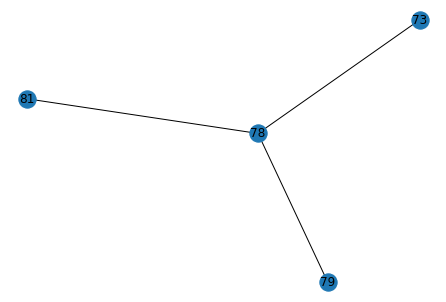

match_branches = [[73, 81]]
edges_to_delete (resolve crossover) = [[73, 78], [73, 79], [78, 79], [78, 81], [79, 81]]
edges_to_create (resolve crossover) = [[73, 81]]
curr_limb.deleted_edges 5 =[[3, 4], [3, 6], [3, 7], [4, 6], [6, 7]]
Skipping endnode 98 because skeletal distance was 737.095834342045 and threshold was 2500
skip_nodes = [98]
edges_to_delete (cut_limb_network) = [[73, 78], [73, 79], [78, 79], [78, 81], [79, 81]]
edges_to_create = [[73, 81]]
Number of connected components = 9
Comp 0 = {135, 142, 15, 144, 145, 19, 20, 21, 151, 25, 154, 28, 158, 159, 160, 161, 34, 35, 42, 43, 44, 49, 50, 51, 52, 183, 184, 60, 62, 67, 79, 92, 93, 95, 96, 97, 98, 102, 103, 104, 105, 106, 108, 110, 116, 117}
Comp 1 = {64, 65, 66, 32, 68.0, 73, 204, 81, 53, 54, 55, 58, 59, 31, 30, 63}
Comp 2 = {0, 1, 6, 10, 11, 13, 14, 16, 17, 18, 22, 23, 24, 26, 27, 29, 33, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 56, 57, 61, 69, 70, 71, 72, 74, 75, 76, 77, 78, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 99,

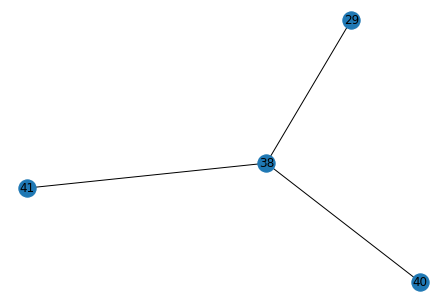

match_branches = [[38, 41], [29, 40]]
edges_to_delete (resolve crossover) = [[29, 38], [29, 41], [38, 40], [40, 41]]
edges_to_create (resolve crossover) = [[38, 41], [29, 40]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[29, 38], [29, 41], [38, 40], [40, 41]]
edges_to_create = [[38, 41], [29, 40]]
Number of connected components = 3
Comp 0 = {0, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 27, 37, 38, 41, 47, 70, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 87, 88}
Comp 1 = {1, 5, 11, 19, 21, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 71, 72, 83, 84, 85, 86}
Comp 2 = {62}
curr_limb_copy.deleted_edges = [[29, 38], [29, 41], [38, 40], [40, 41]]
curr_limb_copy.created_edges = [[38, 41], [29, 40]]
After get best cut: cut_edges = [[29, 38], [29, 41], [38, 40], [40, 41]], added_edges = [[38, 41], [29, 40]]
total_soma_paths_

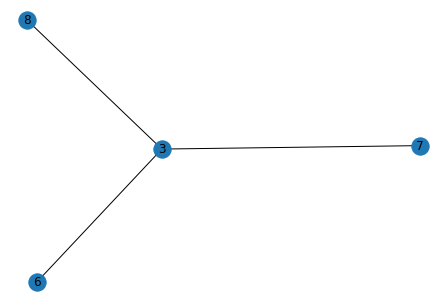

match_branches = [[3, 7]]
edges_to_delete (resolve crossover) = [[3, 6], [3, 8], [6, 7], [6, 8], [7, 8]]
edges_to_create (resolve crossover) = [[3, 7]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[3, 6], [3, 8], [6, 7], [6, 8], [7, 8]]
edges_to_create = [[3, 7]]
Number of connected components = 2
Comp 0 = {0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}
Comp 1 = {1, 19, 6}
curr_limb_copy.deleted_edges = [[3, 6], [3, 8], [6, 7], [6, 8], [7, 8]]
curr_limb_copy.created_edges = [[3, 7]]
After get best cut: cut_edges = [[3, 6], [3, 8], [6, 7], [6, 8], [7, 8]], added_edges = [[3, 7]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
Shortest path = [0, 4, 10, 24, 22, 16, 15, 12, 5]

 --------- START OF GET BEST EDG

  Edge: [0 4]: curr_angle = 28.33
  Edge: [ 4 10]: curr_angle = 31.66
  Edge: [10 24]: curr_angle = 42.14
  Edge: [24 22]: curr_angle = 144.37
  Edge: [22 16]: curr_angle = 56.26
  Edge: [16 15]: curr_angle = 127.63
  Edge: [15 12]: curr_angle = 24.91
  Edge: [12  5]: curr_angle = 69.79

Total time for doubling_back = 0.31430959701538086
There were 2 edges that passed doubling back threshold of 100
Winning edge [24 22] had a doubling back of 144.36839626766306
***inside resolve crossover!!!!****
coordinate_branches = [22, 24, 26]
22 = red
24 = aqua
26 = purple
Angle between 22 and 24 = 126.33 
Angle between 22 and 26 = 29.92 
Angle between 24 and 26 = 34.2 
Final Matches = [[22, 26], [24, 26]]
matched_branches_revised = [[22, 26]]
Original graph


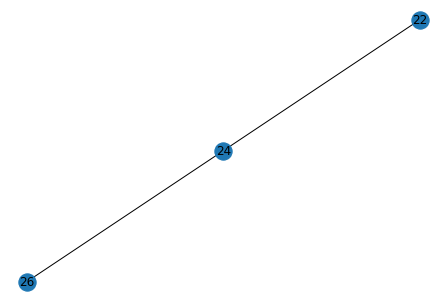

match_branches = [[22, 26]]
edges_to_delete (resolve crossover) = [[22, 24], [24, 26]]
edges_to_create (resolve crossover) = [[22, 26]]
edges_to_delete (cut_limb_network) = [array([22, 24]), array([24, 26])]
edges_to_create = [[22, 26]]
Number of connected components = 3
Comp 0 = {0, 32, 33, 3, 4, 7, 9, 10, 13, 14, 17, 18, 24, 25, 27, 28}
Comp 1 = {1, 19, 6}
Comp 2 = {2, 34, 5, 8, 11, 12, 15, 16, 20, 21, 22, 23, 26, 29, 30, 31}
curr_limb_copy.deleted_edges = [[3, 6], [3, 8], [6, 7], [6, 8], [7, 8], array([22, 24]), array([24, 26])]
curr_limb_copy.created_edges = [[3, 7], [22, 26]]
After get best cut: cut_edges = [array([22, 24]), array([24, 26])], added_edges = [[22, 26]]
total_soma_paths_to_cut = [[3, 6], [3, 8], [6, 7], [6, 8], [7, 8]]
-----------counter = 1------------
 Cut iteration 2
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number

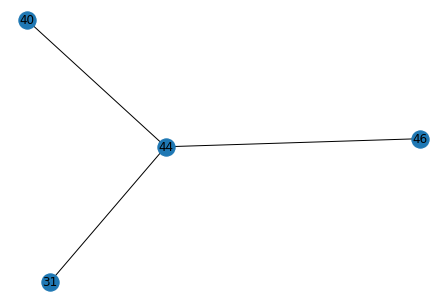

match_branches = [[31, 46], [40, 44]]
edges_to_delete (resolve crossover) = [[31, 40], [31, 44], [40, 46], [44, 46]]
edges_to_create (resolve crossover) = [[31, 46], [40, 44]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[31, 40], [31, 44], [40, 46], [44, 46]]
edges_to_create = [[31, 46], [40, 44]]
Number of connected components = 3
Comp 0 = {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 48, 49, 50, 51, 52}
Comp 1 = {1, 43, 46, 47, 29, 31}
Comp 2 = {45}
curr_limb_copy.deleted_edges = [[31, 40], [31, 44], [40, 46], [44, 46]]
curr_limb_copy.created_edges = [[31, 46], [40, 44]]
After get best cut: cut_edges = [[31, 40], [31, 44], [40, 46], [44, 46]], added_edges = [[31, 46], [40, 44]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total numb

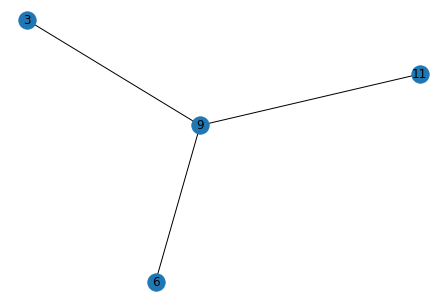

match_branches = [[6, 9], [3, 11]]
edges_to_delete (resolve crossover) = [[3, 6], [3, 9], [6, 11], [9, 11]]
edges_to_create (resolve crossover) = [[6, 9], [3, 11]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[3, 6], [3, 9], [6, 11], [9, 11]]
edges_to_create = [[6, 9], [3, 11]]
Number of connected components = 2
Comp 0 = {2, 3, 5, 7, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
Comp 1 = {0, 1, 4, 6, 8, 9, 10, 13}
curr_limb_copy.deleted_edges = [[3, 6], [3, 9], [6, 11], [9, 11]]
curr_limb_copy.created_edges = [[6, 9], [3, 11]]
After get best cut: cut_edges = [[3, 6], [3, 9], [6, 11], [9, 11]], added_edges = [[6, 9], [3, 11]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 

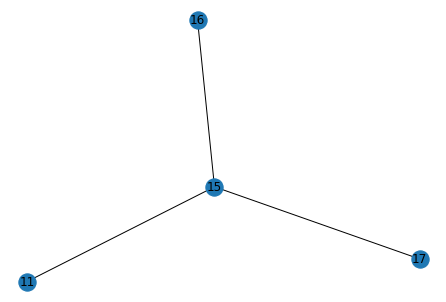

match_branches = [[15, 16], [11, 17]]
edges_to_delete (resolve crossover) = [[11, 15], [11, 16], [15, 17], [16, 17]]
edges_to_create (resolve crossover) = [[15, 16], [11, 17]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 13 because skeletal distance was 1963.9795484123795 and threshold was 2500
skip_nodes = [13]
edges_to_delete (cut_limb_network) = [[11, 15], [11, 16], [15, 17], [16, 17]]
edges_to_create = [[15, 16], [11, 17]]
Number of connected components = 2
Comp 0 = {0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16}
Comp 1 = {3, 17, 2, 11}
curr_limb_copy.deleted_edges = [[11, 15], [11, 16], [15, 17], [16, 17]]
curr_limb_copy.created_edges = [[15, 16], [11, 17]]
After get best cut: cut_edges = [[11, 15], [11, 16], [15, 17], [16, 17]], added_edges = [[15, 16], [11, 17]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL =

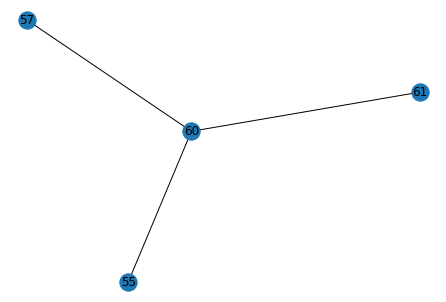

match_branches = [[55, 61], [57, 60]]
edges_to_delete (resolve crossover) = [[55, 57], [55, 60], [57, 61], [60, 61]]
edges_to_create (resolve crossover) = [[55, 61], [57, 60]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[55, 57], [55, 60], [57, 61], [60, 61]]
edges_to_create = [[55, 61], [57, 60]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Comp 1 = {61, 55}
curr_limb_copy.deleted_edges = [[55, 57], [55, 60], [57, 61], [60, 61]]
curr_limb_copy.created_edges = [[55, 61], [57, 60]]
After get best cut: cut_edges = [[55, 57], [55, 60], [57, 61], [60, 61]], added_edges = [[55, 61], [57, 60]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 

  Edge: [16 17]: curr_angle = 36.49
  Edge: [17 19]: curr_angle = 33.73
  Edge: [19 20]: curr_angle = 9.44
  Edge: [20 24]: curr_angle = 17.52
  Edge: [24 35]: curr_angle = 38.71
  Edge: [35 74]: curr_angle = 68.93
  Edge: [74 56]: curr_angle = 62.67
  Edge: [56 60]: curr_angle = 33.69
  Edge: [60 57]: curr_angle = 22.89
  Edge: [57 58]: curr_angle = 17.34
  Edge: [58 68]: curr_angle = 23.52
  Edge: [68 67]: curr_angle = 21.33
  Edge: [67 64]: curr_angle = 21.73
  Edge: [64 65]: curr_angle = 19.74

Total time for doubling_back = 2.400456666946411

Attempting the width jump check (attempting from both sides)
  Edge: [16 17]: jump = -242.09
  Edge: [17 19]: jump = -137.76
  Edge: [19 20]: jump = 81.97
  Edge: [20 24]: jump = -1.29
  Edge: [24 35]: jump = -29.66
  Edge: [35 74]: jump = -5.87
  Edge: [74 56]: jump = 16.98
  Edge: [56 60]: jump = 97.49
  Edge: [60 57]: jump = -43.17
  Edge: [57 58]: jump = 176.66
  Edge: [58 68]: jump = 124.77
  Edge: [68 67]: jump = -0.47
  Edge: [67 64]: 

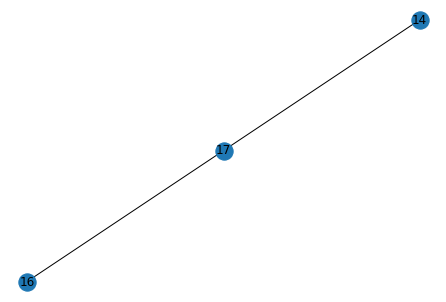

match_branches = []
edges_to_delete (resolve crossover) = [[14, 16], [14, 17], [16, 17]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([14, 16]), array([14, 17]), array([16, 17])]
edges_to_create = []
Number of connected components = 4
Comp 0 = {16}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
Comp 2 = {15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Comp 3 = {61, 55}
curr_limb_copy.deleted_edges = [[55, 57], [55, 60], [57, 61], [60, 61], array([14, 16]), array([14, 17]), array([16, 17])]
curr_limb_copy.created_edges = [[55, 61], [57, 60]]
After get best cut: cut_edges = [array([14, 16]), array([14, 17]), array([16, 17])], added_edges = []
total_soma_paths_to_cut = [[55, 57], [55, 60], [57, 61], [60, 61]]
-----------counter = 1------------
 Cut iterati

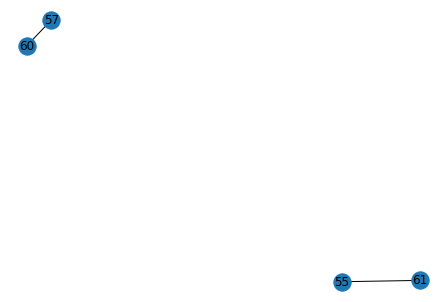

match_branches = [[55, 61], [57, 60]]
edges_to_delete (resolve crossover) = [[55, 57], [55, 60], [57, 61], [60, 61]]
edges_to_create (resolve crossover) = [[55, 61], [57, 60]]
curr_limb.deleted_edges 5 =[[55, 57], [55, 60], [57, 61], [60, 61], array([14, 16]), array([14, 17]), array([16, 17])]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[55, 57], [55, 60], [57, 61], [60, 61]]
edges_to_create = [[55, 61], [57, 60]]
Number of connected components = 4
Comp 0 = {16}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
Comp 2 = {15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Comp 3 = {61, 55}
curr_limb_copy.deleted_edges = [[55, 57], [55, 60], [57, 61], [60, 61], array([14, 16]), array([14, 17]), array([16, 17]), [55, 57], [55, 60], [57, 61], [60, 61]]
curr_limb_copy.created_edges = [[55, 61]

  Edge: [65 64]: curr_angle = 19.74
  Edge: [64 67]: curr_angle = 21.73
  Edge: [67 68]: curr_angle = 21.33
  Edge: [68 58]: curr_angle = 23.52
  Edge: [58 57]: curr_angle = 17.34
  Edge: [57 60]: curr_angle = 22.89
  Edge: [60 59]: curr_angle = 24.47
  Edge: [59 63]: curr_angle = 8.72
  Edge: [63 66]: curr_angle = 37.13

Total time for doubling_back = 0.8377141952514648

Attempting the width jump check (attempting from both sides)
  Edge: [65 64]: jump = -125.65
  Edge: [64 67]: jump = -41.24
  Edge: [67 68]: jump = 0.47
  Edge: [68 58]: jump = -124.77
  Edge: [58 57]: jump = -176.66
  Edge: [57 60]: jump = 43.17
  Edge: [60 59]: jump = -94.98
  Edge: [59 63]: jump = -174.35
  Edge: [63 66]: jump = -22.08
Total time for width = 0.8762500286102295
Path starting at 65 had err_edges: []
  Edge: [66 63]: jump = 22.08
  Edge: [63 59]: jump = 174.35
  Edge: [59 60]: jump = 94.98
  Edge: [60 57]: jump = -43.17
  Edge: [57 58]: jump = 176.66
  Edge: [58 68]: jump = 124.77
  Edge: [68 67]: jum

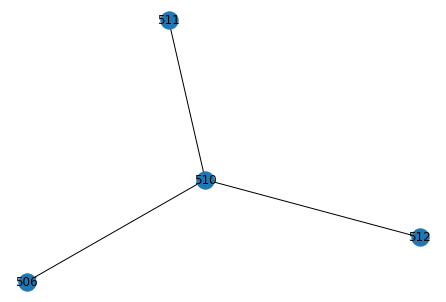

match_branches = [[506, 510]]
edges_to_delete (resolve crossover) = [[506, 511], [506, 512], [510, 511], [510, 512], [511, 512]]
edges_to_create (resolve crossover) = [[506, 510]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[506, 511], [506, 512], [510, 511], [510, 512], [511, 512]]
edges_to_create = [[506, 510]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 

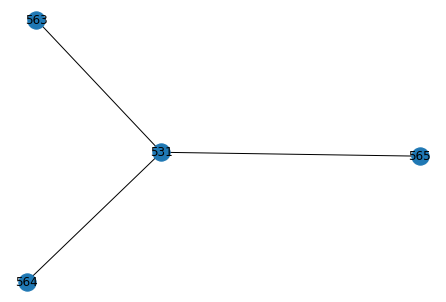

match_branches = [[531, 565], [563, 564]]
edges_to_delete (resolve crossover) = [[531, 563], [531, 564], [563, 565], [564, 565]]
edges_to_create (resolve crossover) = [[531, 565], [563, 564]]
curr_limb.deleted_edges 5 =[[506, 511], [506, 512], [510, 511], [510, 512], [511, 512]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[531, 563], [531, 564], [563, 565], [564, 565]]
edges_to_create = [[531, 565], [563, 564]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 

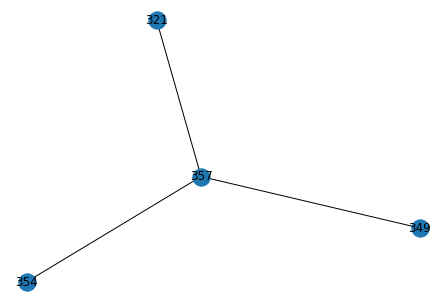

match_branches = [[321, 357], [349, 354]]
edges_to_delete (resolve crossover) = [[321, 349], [321, 354], [349, 357], [354, 357]]
edges_to_create (resolve crossover) = [[321, 357], [349, 354]]
curr_limb.deleted_edges 5 =[[506, 511], [506, 512], [510, 511], [510, 512], [511, 512], [531, 563], [531, 564], [563, 565], [564, 565]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[321, 349], [321, 354], [349, 357], [354, 357]]
edges_to_create = [[321, 357], [349, 354]]
Number of connected components = 5
Comp 0 = {384, 356, 382, 387, 388, 386, 136, 392, 264, 269, 531, 403, 406, 407, 536, 412, 414, 415, 416, 418, 419, 294, 423, 433, 177, 565, 437, 445, 321, 322, 450, 68, 452, 453, 451, 454, 458, 332, 461, 81, 339, 468, 469, 340, 471, 341, 473, 212, 475, 476, 507, 350, 351, 481, 484, 357, 486, 359, 488, 487, 490, 491, 489, 493, 492, 360, 505, 497, 498, 379, 501, 502, 374, 248, 377, 506, 123, 124, 381, 510}
Comp 1 = {511}
Comp 2 = {512}
Comp 3 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13

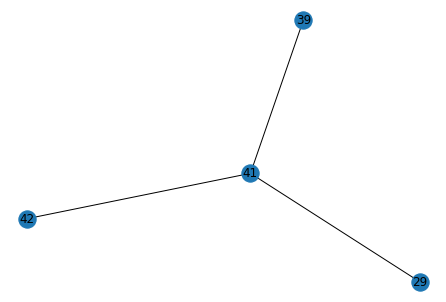

match_branches = [[39, 41]]
edges_to_delete (resolve crossover) = [[29, 39], [29, 41], [29, 42], [39, 42], [41, 42]]
edges_to_create (resolve crossover) = [[39, 41]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[29, 39], [29, 41], [29, 42], [39, 42], [41, 42]]
edges_to_create = [[39, 41]]
Number of connected components = 2
Comp 0 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
Comp 1 = {0, 21, 29}
curr_limb_copy.deleted_edges = [[29, 39], [29, 41], [29, 42], [39, 42], [41, 42]]
curr_limb_copy.created_edges = [[39, 41]]
After get best cut: cut_edges = [[29, 39], [29, 41], [29, 42], [39, 42], [41, 42]], added_edges = [[39, 41]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the en

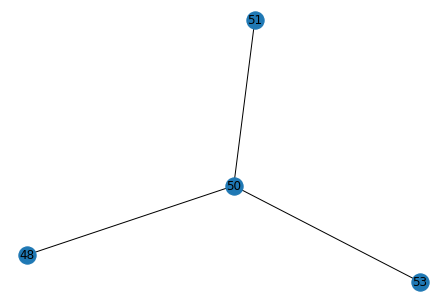

match_branches = [[48, 51]]
edges_to_delete (resolve crossover) = [[48, 50], [48, 53], [50, 51], [50, 53], [51, 53]]
edges_to_create (resolve crossover) = [[48, 51]]
curr_limb.deleted_edges 5 =[[29, 39], [29, 41], [29, 42], [39, 42], [41, 42]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[48, 50], [48, 53], [50, 51], [50, 53], [51, 53]]
edges_to_create = [[48, 51]]
Number of connected components = 5
Comp 0 = {64, 65, 66, 67, 68, 69, 42, 47, 48, 51, 56, 57, 58, 59, 60, 61, 62, 63}
Comp 1 = {0, 21, 29}
Comp 2 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 49, 50, 54, 55}
Comp 3 = {53}
Comp 4 = {52}
curr_limb_copy.deleted_edges = [[29, 39], [29, 41], [29, 42], [39, 42], [41, 42], [48, 50], [48, 53], [50, 51], [50, 53], [51, 53]]
curr_limb_copy.created_edges = [[39, 41], [48, 51]]
After get best cut: cut_edges = [[48, 50], [48, 53], [50, 51], [50, 53], [51, 53]], 

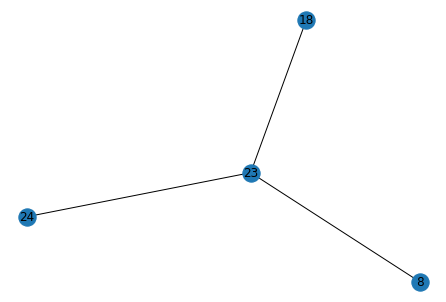

match_branches = []
edges_to_delete (resolve crossover) = [[8, 18], [8, 23], [8, 24], [18, 23], [18, 24], [23, 24]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[]
Skipping endnode 10 because skeletal distance was 1133.1040532681482 and threshold was 2500
skip_nodes = [10]
edges_to_delete (cut_limb_network) = [[8, 18], [8, 23], [8, 24], [18, 23], [18, 24], [23, 24]]
edges_to_create = []
Number of connected components = 5
Comp 0 = {33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 19, 24}
Comp 1 = {8}
Comp 2 = {17, 18, 12}
Comp 3 = {0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32}
Comp 4 = {22}
curr_limb_copy.deleted_edges = [[8, 18], [8, 23], [8, 24], [18, 23], [18, 24], [23, 24]]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [[8, 18], [8, 23], [8, 24], [18, 23], [18, 24], [23, 24]], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs a

In [10]:
start_time = time.time()
if not test_mode:
    time.sleep(random.randint(0, 800))
print('Populate Started')
if not test_mode:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
else:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
print('Populate Done')

print(f"Total time for NeuronSplitSuggestions populate = {time.time() - start_time}")